In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [5]:
flood_policies = pd.read_csv("nfip-flood-policies.csv", header=0, low_memory = False, memory_map = True)
# https://www.kaggle.com/datasets/lynma01/femas-national-flood-insurance-policy-database
flood_policies.head()

,agriculturestructureindicator,basefloodelevation,basementenclosurecrawlspacetype,cancellationdateoffloodpolicy,censustract,condominiumindicator,construction,countycode,crsdiscount,deductibleamountinbuildingcoverage,...,primaryresidenceindicator,propertystate,reportedzipcode,ratemethod,regularemergencyprogramindicator,reportedcity,smallbusinessindicatorbuilding,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,totalinsurancepremiumofthepolicy
0,NaN,NaN,2.0,NaN,3.301304e+10,N,N,33013.0,0.00,0,...,Y,NH,03278,7,R,WARNER,NaN,250000.0,100000.0,375.0
1,NaN,NaN,0.0,NaN,2.206304e+10,N,N,22063.0,0.05,1,...,Y,LA,70726,1,R,DENHAM SPRINGS,NaN,16400.0,8800.0,280.0
2,NaN,NaN,0.0,NaN,4.505106e+10,N,N,45051.0,0.00,0,...,Y,SC,29579,7,R,MYRTLE BEACH,NaN,250000.0,100000.0,335.0
3,NaN,519.0,2.0,2016-04-01,1.055001e+09,N,N,1055.0,0.00,1,...,Y,AL,35901,2,R,GADSDEN,NaN,174900.0,21000.0,916.0
4,NaN,7.0,0.0,NaN,1.208600e+10,N,N,12086.0,0.00,0,...,Y,FL,33160,1,R,GOLDEN BEACH,NaN,250000.0,100000.0,1288.0


In [6]:
flood_policies.isna().sum()

agriculturestructureindicator         38923313
basefloodelevation                    33636760
basementenclosurecrawlspacetype            803
cancellationdateoffloodpolicy         43614058
censustract                             467120
condominiumindicator                         7
construction                                14
countycode                               49000
crsdiscount                                  1
deductibleamountinbuildingcoverage      661994
deductibleamountincontentscoverage     5561585
elevatedbuildingindicator                  259
elevationcertificateindicator         32606398
elevationdifference                          1
federalpolicyfee                             1
floodzone                               169146
hfiaasurcharge                               1
houseofworshipindicator               34476252
latitude                                338700
locationofcontents                    15389768
longitude                               338700
lowestadjacen

In [32]:
flood_policies['premium_rate'] = flood_policies['totalinsurancepremiumofthepolicy']/(flood_policies['totalbuildinginsurancecoverage']+flood_policies['totalcontentsinsurancecoverage'])

In [33]:
df = flood_policies[['floodzone','latitude','longitude','propertystate','reportedzipcode','reportedcity',
                     'smallbusinessindicatorbuilding', 'obstructiontype', 
                     'nonprofitindicator', 'houseofworshipindicator', 'agriculturestructureindicator',
                     'cancellationdateoffloodpolicy','originalnbdate','policyeffectivedate','policyterminationdate',
                     'totalbuildinginsurancecoverage','totalcontentsinsurancecoverage','totalinsurancepremiumofthepolicy', 'premium_rate']]

In [34]:
mask = df[['smallbusinessindicatorbuilding', 'obstructiontype', 
                     'nonprofitindicator', 'houseofworshipindicator', 'agriculturestructureindicator',
                     'cancellationdateoffloodpolicy']].isna()

In [35]:
df[mask] = "Unknown"

C:\Users\Hobbs\AppData\Local\Temp\ipykernel_8900\247680975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[mask] = "Unknown"
C:\Users\Hobbs\AppData\Local\Temp\ipykernel_8900\247680975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[mask] = "Unknown"


In [36]:
df.isna().sum()

floodzone                           169146
latitude                            338700
longitude                           338700
propertystate                            1
reportedzipcode                          8
reportedcity                            12
smallbusinessindicatorbuilding           0
obstructiontype                          0
nonprofitindicator                       0
houseofworshipindicator                  0
agriculturestructureindicator            0
cancellationdateoffloodpolicy            0
originalnbdate                           1
policyeffectivedate                      1
policyterminationdate                    1
totalbuildinginsurancecoverage           1
totalcontentsinsurancecoverage           1
totalinsurancepremiumofthepolicy         1
premium_rate                             3
dtype: int64

In [37]:
df = df.dropna()

In [12]:
state_count = df['propertystate'].value_counts()
state_count

propertystate
FL    14991292
TX     7235397
LA     5575140
CA     2772778
NJ     2071376
NY     1821067
SC     1788859
NC     1451943
VA     1165759
GA     1031394
MS      797567
PA      721401
MA      548519
MD      522594
WA      487446
AL      483323
IL      465654
OH      423586
AZ      374880
CT      370438
TN      342331
OR      341240
IN      319149
PR      290465
MO      276210
KY      266426
MI      264315
DE      230569
WV      219494
AR      218719
CO      218533
HI      207354
OK      184694
NM      177214
IA      171795
WI      169036
RI      153203
ND      149515
NV      148444
NE      135358
KS      134945
MN      134239
ME       93442
NH       81530
ID       73481
MT       63102
SD       58485
VT       45215
UT       41176
AK       32490
WY       27077
DC       16822
VI       15623
GU        2706
AS        2020
CM         113
Name: count, dtype: int64

In [38]:
df_michigan = df[df['propertystate'] == 'MI']

In [39]:
df_michigan['reportedzipcode'].astype(int)
df_michigan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261568 entries, 420 to 50406912
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   floodzone                         261568 non-null  object 
 1   latitude                          261568 non-null  float64
 2   longitude                         261568 non-null  float64
 3   propertystate                     261568 non-null  object 
 4   reportedzipcode                   261568 non-null  object 
 5   reportedcity                      261568 non-null  object 
 6   smallbusinessindicatorbuilding    261568 non-null  object 
 7   obstructiontype                   261568 non-null  object 
 8   nonprofitindicator                261568 non-null  object 
 9   houseofworshipindicator           261568 non-null  object 
 10  agriculturestructureindicator     261568 non-null  object 
 11  cancellationdateoffloodpolicy     261568 non-null  ob

In [40]:
df_michigan = df_michigan.dropna()

In [41]:
mask = df_michigan['floodzone'].str.contains('^A')
df_michigan['High_floodzone'] = False
df_michigan.loc[mask, 'High_floodzone'] = True
mask = df_michigan['floodzone'].str.contains('^V')
df_michigan['Coastal_High_floodzone'] = False
df_michigan.loc[mask, 'Coastal_High_floodzone'] = True
mask = df_michigan['floodzone'].str.contains('^[BCX]')
df_michigan['Low_Moderate_floodzone'] = False
df_michigan.loc[mask, 'Low_Moderate_floodzone'] = True
mask = df_michigan['floodzone'].str.contains('^D')
df_michigan['Undetermined_floodzone'] = False
df_michigan.loc[mask, 'Undetermined_floodzone'] = True
df_michigan.head()

,floodzone,latitude,longitude,propertystate,reportedzipcode,reportedcity,smallbusinessindicatorbuilding,obstructiontype,nonprofitindicator,houseofworshipindicator,...,policyeffectivedate,policyterminationdate,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,totalinsurancepremiumofthepolicy,premium_rate,High_floodzone,Coastal_High_floodzone,Low_Moderate_floodzone,Undetermined_floodzone
420,C,43.1,-86.2,MI,49456,SPRING LAKE,Unknown,Unknown,Unknown,Unknown,...,2009-09-06,2010-09-06,125000.0,50000.0,294.0,0.001680,False,False,True,False
636,X,42.3,-83.3,MI,48125,DEARBORN HGTS,Unknown,Unknown,Unknown,Unknown,...,2009-01-12,2010-01-12,172700.0,0.0,585.0,0.003387,False,False,True,False
764,C,42.1,-86.4,MI,49085,SAINT JOSEPH,Unknown,10,Unknown,Unknown,...,2009-06-16,2010-06-16,150000.0,60000.0,283.0,0.001348,False,False,True,False
1161,AE,42.8,-86.2,MI,49434,MACATAWA,Unknown,Unknown,Unknown,Unknown,...,2009-07-20,2010-07-20,500000.0,0.0,2500.0,0.005000,True,False,False,False
1349,AE,42.3,-83.8,MI,48103,ANN ARBOR,Unknown,Unknown,Unknown,Unknown,...,2009-04-08,2010-04-08,70000.0,0.0,638.0,0.009114,True,False,False,False


Text(0.5, 1.0, 'Count of Properties in Each Flood Zone')

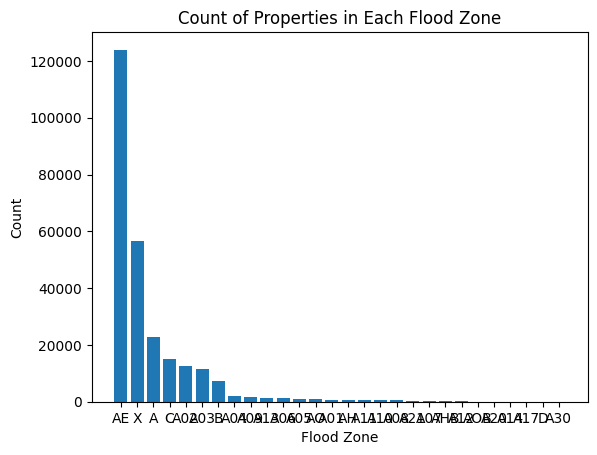

In [42]:
floodzone_counts = df_michigan['floodzone'].value_counts()
labels = floodzone_counts.index
heights = floodzone_counts.values

plt.bar(labels, heights)
plt.xlabel("Flood Zone")
plt.ylabel("Count")
plt.title("Count of Properties in Each Flood Zone")

([0, 1, 2, 3],
 [Text(0, 0, 'High_floodzone'),
  Text(1, 0, 'Coastal_High_floodzone'),
  Text(2, 0, 'Low_Moderate_floodzone'),
  Text(3, 0, 'Undetermined_floodzone')])

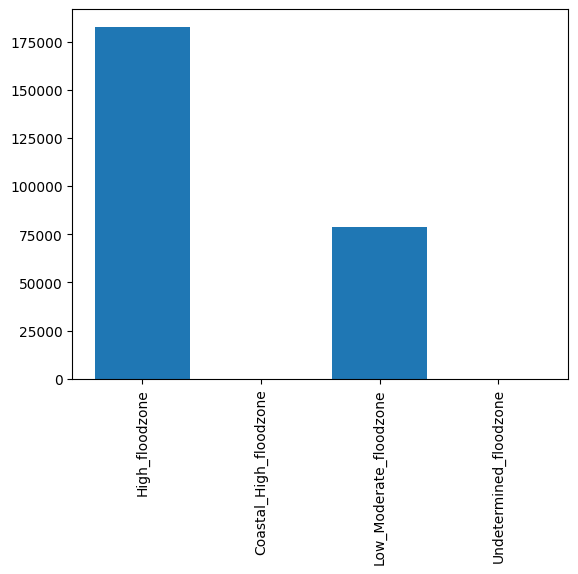

In [50]:
floodzone_counts = df_michigan[["High_floodzone","Coastal_High_floodzone","Low_Moderate_floodzone","Undetermined_floodzone"]].sum()
labels = floodzone_counts.index
heights = floodzone_counts.values
plt.bar(labels, heights)
plt.xticks(rotation = 90)